In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas==1.3.1

In [ ]:
!pip install neattext

In [ ]:
!pip3 install  pyLDAvis --quiet

In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt

# spacy for lemmatization
import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import plotly.express as px
import nltk
nltk.download('all')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import neattext.functions as nf
from textblob import TextBlob, Word
import re
import string

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [ ]:
path = '/content/drive/MyDrive/T5camp/Anime_project/'

anime = pd.read_csv(path + 'animes.csv')
# profiles = pd.read_csv(path + 'profiles.csv')
# reviews = pd.read_csv(path + 'reviews.csv')

In [ ]:
anime.head(100)

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,"Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the Spring tournament instead. \r\n \r\nWhen they receive an invitation from long-standing rival Nekoma High, Karasuno agrees to take part in a large training camp alongside many notable volleyball teams in Tokyo and even some national level players. By playing with some of the toughest teams in Japan, they hope not only to sharpen their skills, but ...","['Comedy', 'Sports', 'Drama', 'School', 'Shounen']","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/76662.jpg,https://myanimelist.net/anime/28891/Haikyuu_Second_Season
1,23273,Shigatsu wa Kimi no Uso,"Music accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. \r\n \r\nTwo years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who...","['Drama', 'Music', 'Romance', 'School', 'Shounen']","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/67177.jpg,https://myanimelist.net/anime/23273/Shigatsu_wa_Kimi_no_Uso
2,34599,Made in Abyss,"The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface. \r\n \r\nRiko, daughter of the missing White Whistle...","['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'Fantasy']","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/86733.jpg,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, something of equal value must be lost."" \r\n \r\nAlchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit...","['Action', 'Military', 'Adventure', 'Comedy', 'Drama', 'Magic', 'Fantasy', 'Shounen']","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/96541.jpg,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood
4,31758,Kizumonogatari III: Reiketsu-hen,"After helping revive the legendary vampire Kiss-shot Acerola-orion Heart-under-blade, Koyomi Araragi has become a vampire himself and her servant. Kiss-shot is certain she can turn him back into a human, but only once regaining her full power. \r\n \r\nAraragi has hunted down the three vampire hunters that defeated Kiss-shot and retrieved her limbs to return her to full strength. However, now that Araragi has almost accomplished what he’s been fighting for this whole time, he has to conside...","['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/81576.jpg,https://myanimelist.net/anime/31758/Kizumonogatari_III__Reiketsu-hen
...,...,...,...,...,...,...,...,...,...,...,...,...
95,82,Mobile Suit Gundam 0080: War in the Pocket,"Al

In [ ]:
# delete unnecessary genre
anime = anime[anime['genre'].str.contains('Hentai')==False]
anime

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,"Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the Spring tournament instead. \r\n \r\nWhen they receive an invitation from long-standing rival Nekoma High, Karasuno agrees to take part in a large training camp alongside many notable volleyball teams in Tokyo and even some national level players. By playing with some of the toughest teams in Japan, they hope not only to sharpen their skills, but ...","['Comedy', 'Sports', 'Drama', 'School', 'Shounen']","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/76662.jpg,https://myanimelist.net/anime/28891/Haikyuu_Second_Season
1,23273,Shigatsu wa Kimi no Uso,"Music accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. \r\n \r\nTwo years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who...","['Drama', 'Music', 'Romance', 'School', 'Shounen']","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/67177.jpg,https://myanimelist.net/anime/23273/Shigatsu_wa_Kimi_no_Uso
2,34599,Made in Abyss,"The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface. \r\n \r\nRiko, daughter of the missing White Whistle...","['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'Fantasy']","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/86733.jpg,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, something of equal value must be lost."" \r\n \r\nAlchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit...","['Action', 'Military', 'Adventure', 'Comedy', 'Drama', 'Magic', 'Fantasy', 'Shounen']","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/96541.jpg,https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood
4,31758,Kizumonogatari III: Reiketsu-hen,"After helping revive the legendary vampire Kiss-shot Acerola-orion Heart-under-blade, Koyomi Araragi has become a vampire himself and her servant. Kiss-shot is certain she can turn him back into a human, but only once regaining her full power. \r\n \r\nAraragi has hunted down the three vampire hunters that defeated Kiss-shot and retrieved her limbs to return her to full strength. However, now that Araragi has almost accomplished what he’s been fighting for this whole time, he has to conside...","['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/81576.jpg,https://myanimelist.net/anime/31758/Kizumonogatari_III__Reiketsu-hen
...,...,...,...,...,...,...,...,...,...,...,...,...
19306,32979,Flip Flappers,"Cocona is an average midd

In [ ]:
pd.options.display.max_colwidth = 500
syn = anime['synopsis']
syn

0        Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the Spring tournament instead.  \r\n \r\nWhen they receive an invitation from long-standing rival Nekoma High, Karasuno agrees to take part in a large training camp alongside many notable volleyball teams in Tokyo and even some national level players. By playing with some of the toughest teams in Japan, they hope not only to sharpen their skills, but ...
1        Music accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. \r\n  \r\nTwo years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori

# Preprocessing

In [ ]:
syn = syn.astype('str')
syn = syn.apply(lambda text: text.lower())
syn = syn.apply(nf.remove_multiple_spaces)
syn = syn.apply(nf.remove_puncts)
syn = syn.apply(nf.remove_stopwords)
syn = syn.apply(nf.remove_numbers)
syn = syn.apply(nf.remove_special_characters)

In [ ]:
# lemmatization for LSA model
lsa_syn = syn
lemmatizer = WordNetLemmatizer()
def lemmatize_words_v(text):
    return " ".join([lemmatizer.lemmatize(word,'v') for word in text.split()])
def lemmatize_words_n(text):
    return " ".join([lemmatizer.lemmatize(word,'n') for word in text.split()])
lsa_syn = lsa_syn.apply(lambda text: lemmatize_words_v(text))
lsa_syn = lsa_syn.apply(lambda text: lemmatize_words_n(text))
lsa_syn

0        follow participation interhigh karasuno high school volleyball team attempt refocus effort aim conquer spring tournament instead receive invitation longstanding rival nekoma high karasuno agree large train camp alongside notable volleyball team tokyo national level player play toughest team japan hope sharpen skill come new attack strengthen hinata kageyama attempt devise powerful weapon possibly break sturdiest block face chance victory senior player graduate member karasunos volleyball tea...
1        music accompany path human metronome prodigious pianist kousei arima pas mother saki arima kousei fall downward spiral render unable hear sound piano year later kousei avoid piano leave admirer rival live colorless life alongside friend tsubaki sawabe ryouta watari change meet beautiful violinist kaori miyazono stir world set journey face music base manga series shigatsu wa kimi uso approach story kouseis recovery discover music play note perfectly single melody bring fresh spr

# LSA Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#use CountVectorizer and TfidfVectorizer to convert text into a matrix representation 
#vectorizer = CountVectorizer()
#doc_word = vectorizer.fit_transform(anime['synopsis'])

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(lsa_syn)

tf= TfidfVectorizer()
tfidf= tf.fit_transform(lsa_syn)

In [ ]:
tfidf.shape

(16739, 41173)

In [ ]:
#Train two LSA model on one using count vectorizer and the other uses tfidf
n_com=18
svd = TruncatedSVD(n_components=n_com, random_state=42)
t= svd.fit_transform(tfidf)

svd2 = TruncatedSVD(n_components=n_com, random_state=42)
t2= svd2.fit_transform(doc_word)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """display topics and the group of words that repreasent that topic"""
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
num=7
#model trained using Count Vectorizer
display_topics(svd2, vectorizer.get_feature_names_out(), num)


Topic  0
source, world, school, girl, mal, write, rewrite

Topic  1
school, high, student, write, rewrite, mal, girl

Topic  2
source, school, episode, girl, ann, series, story

Topic  3
episode, series, new, write, mal, rewrite, video

Topic  4
world, school, high, episode, game, student, video

Topic  5
earth, school, year, high, team, new, planet

Topic  6
video, music, girl, song, earth, planet, year

Topic  7
girl, episode, earth, series, special, power, war

Topic  8
new, girl, friend, game, team, find, ann

Topic  9
new, life, live, girl, year, human, earth

Topic  10
friend, episode, earth, find, new, day, live

Topic  11
friend, story, earth, year, time, love, series

Topic  12
game, find, team, live, year, earth, play

Topic  13
year, time, day, new, family, love, father

Topic  14
game, friend, live, team, time, power, day

Topic  15
boy, story, human, team, new, father, name

Topic  16
human, time, demon, game, power, find, student

Topic  17
day, game, story, power, stude

In [ ]:
#model trained using tfidf Vectorizer
display_topics(svd, tf.get_feature_names_out(), num)


Topic  0
nan, kusuo, saiki, mr, chapter, adaptation, final

Topic  1
episode, source, series, special, girl, short, story

Topic  2
episode, special, volume, dvd, include, release, unaired

Topic  3
video, music, song, uta, minna, nhks, feature

Topic  4
short, movie, season, series, second, film, tv

Topic  5
episode, season, recap, second, air, series, tv

Topic  6
season, second, volume, bundle, th, manga, include

Topic  7
manga, th, bundle, volume, series, anime, ovum

Topic  8
series, special, tv, synopsis, click, add, update

Topic  9
movie, episode, short, anpanman, korean, th, recap

Topic  10
film, movie, educational, safety, traffic, star, tv

Topic  11
school, high, student, girl, club, movie, film

Topic  12
synopsis, click, update, add, information, series, short

Topic  13
special, uta, minna, nhks, program, feature, bundle

Topic  14
uta, minna, nhks, program, feature, unaired, include

Topic  15
add, anime, synopsis, click, update, information, special

Topic  16
anim

# LDA Model

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(syn))
print(data_words[:1])

[['following', 'participation', 'interhigh', 'karasuno', 'high', 'school', 'volleyball', 'team', 'attempts', 'refocus', 'efforts', 'aiming', 'conquer', 'spring', 'tournament', 'instead', 'receive', 'invitation', 'longstanding', 'rival', 'nekoma', 'high', 'karasuno', 'agrees', 'large', 'training', 'camp', 'alongside', 'notable', 'volleyball', 'teams', 'tokyo', 'national', 'level', 'players', 'playing', 'toughest', 'teams', 'japan', 'hope', 'sharpen', 'skills', 'come', 'new', 'attacks', 'strengthen', 'hinata', 'kageyama', 'attempt', 'devise', 'powerful', 'weapon', 'possibly', 'break', 'sturdiest', 'blocks', 'facing', 'chance', 'victory', 'senior', 'players', 'graduate', 'members', 'karasunos', 'volleyball', 'team', 'learn', 'settle', 'differences', 'train', 'harder', 'hope', 'overcome', 'formidable', 'opponents', 'old', 'newincluding', 'archrival', 'aoba', 'jousai', 'worldclass', 'setter', 'tooru', 'oikawa', 'written', 'mal', 'rewrite']]


In [ ]:
# Define function for lemmatization for LDA model
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecat

In [ ]:
print(data_lemmatized[:1])

[['follow', 'participation', 'team', 'attempt', 'refocus', 'effort', 'aim', 'conquer', 'spring', 'tournament', 'instead', 'receive', 'invitation', 'longstanding', 'rival', 'high', 'agree', 'large', 'training', 'camp', 'notable', 'team', 'national', 'level', 'player', 'play', 'tough', 'team', 'skill', 'come', 'new', 'attack', 'strengthen', 'powerful', 'weapon', 'possibly', 'break', 'sturdy', 'block', 'face', 'chance', 'victory', 'senior', 'player', 'graduate', 'member', 'team', 'learn', 'settle', 'difference', 'train', 'hard', 'hope', 'overcome', 'formidable', 'opponent', 'old', 'newinclude', 'archrival', 'write']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 4), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('agree', 1),
  ('aim', 1),
  ('archrival', 1),
  ('attack', 1),
  ('attempt', 1),
  ('block', 1),
  ('break', 1),
  ('camp', 1),
  ('chance', 1),
  ('come', 1),
  ('conquer', 1),
  ('difference', 1),
  ('effort', 1),
  ('face', 1),
  ('follow', 1),
  ('formidable', 1),
  ('graduate', 1),
  ('hard', 1),
  ('high', 1),
  ('hope', 1),
  ('instead', 1),
  ('invitation', 1),
  ('large', 1),
  ('learn', 1),
  ('level', 1),
  ('longstanding', 1),
  ('member', 1),
  ('national', 1),
  ('new', 1),
  ('newinclude', 1),
  ('notable', 1),
  ('old', 1),
  ('opponent', 1),
  ('overcome', 1),
  ('participation', 1),
  ('play', 1),
  ('player', 2),
  ('possibly', 1),
  ('powerful', 1),
  ('receive', 1),
  ('refocus', 1),
  ('rival', 1),
  ('senior', 1),
  ('settle', 1),
  ('skill', 1),
  ('spring', 1),
  ('strengthen', 1),
  ('sturdy', 1),
  ('team', 4),
  ('tough', 1),
  ('tournament', 1),
  ('train', 1),
  ('training', 1),
  ('victory', 1),
  ('weapon', 1),
  ('write', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=18, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

In [ ]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.038*"film" + 0.032*"deal" + 0.031*"bundle" + 0.022*"desire" + '
  '0.018*"nature" + 0.017*"mind" + 0.016*"adapt" + 0.015*"owner" + '
  '0.014*"depict" + 0.013*"romantic"'),
 (1,
  '0.031*"monster" + 0.030*"creature" + 0.029*"plan" + 0.026*"ship" + '
  '0.024*"mission" + 0.023*"threat" + 0.021*"far" + 0.020*"alien" + '
  '0.017*"dangerous" + 0.016*"rise"'),
 (2,
  '0.044*"source" + 0.028*"girl" + 0.025*"find" + 0.024*"world" + '
  '0.024*"friend" + 0.020*"life" + 0.017*"live" + 0.017*"young" + 0.015*"know" '
  '+ 0.014*"name"'),
 (3,
  '0.026*"parent" + 0.022*"believe" + 0.018*"goal" + 0.016*"daughter" + '
  '0.016*"prepare" + 0.016*"study" + 0.015*"watch" + 0.013*"matter" + '
  '0.013*"completely" + 0.013*"crush"'),
 (4,
  '0.037*"death" + 0.035*"demon" + 0.029*"spirit" + 0.024*"dark" + '
  '0.024*"hide" + 0.022*"choose" + 0.019*"warrior" + 0.018*"village" + '
  '0.017*"bear" + 0.016*"possess"'),
 (5,
  '0.045*"event" + 0.032*"robot" + 0.029*"ago" + 0.027*"ghost" + 0.023*"thi

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n


Perplexity:  -8.800594592965284

Coherence Score:  0.4145295446563852


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.384660 -0.204039       1        1  26.681675
12     0.283840  0.151815       2        1  13.724988
16     0.004780 -0.051498       3        1   6.506342
11     0.054834  0.360433       4        1   6.114471
7      0.014576  0.004287       5        1   4.620684
9     -0.029399 -0.035051       6        1   4.573881
14    -0.038603 -0.004821       7        1   4.083475
1     -0.026072 -0.009236       8        1   3.823303
4     -0.037005 -0.006051       9        1   3.713228
5     -0.053416 -0.022510      10        1   3.487909
3     -0.059018 -0.022447      11        1   3.214887
15    -0.065284 -0.019647      12        1   3.107856
17    -0.061673 -0.021975      13        1   3.102604
6     -0.065469 -0.020868      14        1   3.080464
13    -0.072932 -0.023819      15        1   2.736423
8     -0.073267 -0.018647      16        1   2.616952
0     -0.082117 -0.030203      17        1   2.525253
10    -0.078435 -0.025725      18        1   2.285605, topic_info=            Term         Freq        Total Category  logprob  loglift
590       school  2156.000000  2156.000000  Default  30.0000  30.0000
248        story  2109.000000  2109.000000  Default  29.0000  29.0000
731       source  4691.000000  4691.000000  Default  28.0000  28.0000
55         write  2988.000000  2988.000000  Default  27.0000  27.0000
390      student  1459.000000  1459.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3503      inform    50.913099    51.640580  Topic18  -5.1967   3.7644
2885     destine    49.109817    49.837298  Topic18  -5.2328   3.7638
6891   planetary    48.094139    48.821629  Topic18  -5.2537   3.7635
2287      vision    48.038704    48.766185  Topic18  -5.2548   3.7635
743   historical    47.828625    48.556107  Topic18  -5.2592   3.7634

[586 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
924      11  0.992657  accident
1478     11  0.996207   achieve
1051      8  0.992539       act
1754     10  0.998288    action
782      17  0.994706     adapt
...     ...       ...       ...
55        2  0.999923     write
89        1  0.022405      year
89        2  0.969404      year
89        4  0.007966      year
158       1  0.999824     young

[572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 13, 17, 12, 8, 10, 15, 2, 5, 6, 4, 16, 18, 7, 14, 9, 1, 11])

# Mallet toolkit

In [ ]:
#Download
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2022-01-04 17:27:21--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-01-04 17:27:21--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.66MB/s    in 1.6s    

2022-01-04 17:27:23 (9.66 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
#Unzip
!unzip "mallet-2.0.8.zip" -d "mallet-2.0.8"

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/mallet-2.0.8/
   creating: mallet-2.0.8/mallet-2.0.8/bin/
  inflating: mallet-2.0.8/mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/mallet-2.0.8/build.xml  
   creating: ma

In [ ]:
!ls

drive  mallet-2.0.8  mallet-2.0.8.zip  sample_data


In [ ]:
mallet_path = '/content/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information



In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('world', 0.03309187756519949),
   ('power', 0.016430142943530228),
   ('write', 0.01341945112772281),
   ('human', 0.01289193674973946),
   ('mysterious', 0.012004168650206502),
   ('find', 0.01157958390695161),
   ('begin', 0.009816913912226754),
   ('save', 0.008414497639051503),
   ('secret', 0.007719722604634407),
   ('strange', 0.007591060561223833)]),
 (1,
  [('school', 0.029370665900513234),
   ('write', 0.01932796155302783),
   ('student', 0.018165671973149805),
   ('friend', 0.01782612670262364),
   ('high', 0.015749676779021327),
   ('love', 0.013725464589346115),
   ('team', 0.011570658064853146),
   ('girl', 0.011022161858618573),
   ('game', 0.010891567523800818),
   ('good', 0.010408368484975122)]),
 (2,
  [('year', 0.021298092466860652),
   ('source', 0.02001832093975644),
   ('call', 0.012972841901066925),
   ('battle', 0.010884793620002156),
   ('earth', 0.010318999892229766),
   ('force', 0.009793620002155405),
   ('fight', 0.00907964220282358),
   ('war', 0.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### this will tale a long time to run ~23 min

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/pytho

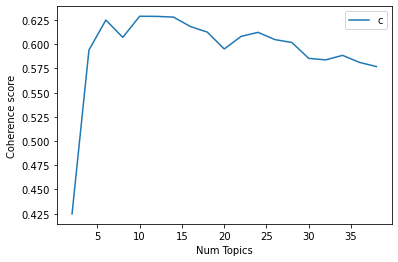

In [ ]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:
# Print the coherence scores
dex = 0
for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of", round(cv, 4), ' index num',dex)
  dex = dex+1

Num Topics = 2  has Coherence Value of 0.4248  index num 0
Num Topics = 4  has Coherence Value of 0.594  index num 1
Num Topics = 6  has Coherence Value of 0.625  index num 2
Num Topics = 8  has Coherence Value of 0.6071  index num 3
Num Topics = 10  has Coherence Value of 0.6289  index num 4
Num Topics = 12  has Coherence Value of 0.6288  index num 5
Num Topics = 14  has Coherence Value of 0.6281  index num 6
Num Topics = 16  has Coherence Value of 0.6183  index num 7
Num Topics = 18  has Coherence Value of 0.6125  index num 8
Num Topics = 20  has Coherence Value of 0.5951  index num 9
Num Topics = 22  has Coherence Value of 0.6082  index num 10
Num Topics = 24  has Coherence Value of 0.6123  index num 11
Num Topics = 26  has Coherence Value of 0.6048  index num 12
Num Topics = 28  has Coherence Value of 0.6018  index num 13
Num Topics = 30  has Coherence Value of 0.5854  index num 14
Num Topics = 32  has Coherence Value of 0.5839  index num 15
Num Topics = 34  has Coherence Value of 

In [ ]:
# Select the model and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.042*"team" + 0.040*"game" + 0.031*"play" + 0.018*"good" + '
  '0.016*"challenge" + 0.015*"face" + 0.014*"player" + 0.012*"join" + '
  '0.012*"win" + 0.011*"rival"'),
 (1,
  '0.127*"source" + 0.095*"story" + 0.041*"boy" + 0.029*"season" + '
  '0.027*"people" + 0.021*"place" + 0.019*"city" + 0.019*"follow" + '
  '0.014*"ghost" + 0.014*"kid"'),
 (2,
  '0.075*"year" + 0.058*"time" + 0.037*"end" + 0.030*"set" + 0.027*"find" + '
  '0.026*"source" + 0.025*"leave" + 0.024*"decide" + 0.020*"plan" + '
  '0.020*"return"'),
 (3,
  '0.034*"earth" + 0.028*"war" + 0.025*"planet" + 0.021*"year" + 0.021*"robot" '
  '+ 0.021*"space" + 0.018*"fight" + 0.016*"pilot" + 0.015*"force" + '
  '0.014*"attack"'),
 (4,
  '0.057*"power" + 0.034*"fight" + 0.026*"evil" + 0.023*"monster" + '
  '0.022*"demon" + 0.018*"protect" + 0.017*"battle" + 0.016*"spirit" + '
  '0.016*"save" + 0.015*"defeat"'),
 (5,
  '0.061*"music" + 0.056*"video" + 0.055*"episode" + 0.050*"special" + '
  '0.049*"include" + 0.045*"feat

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=syn):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=syn)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3899,"team, game, play, good, challenge, face, player, join, win, rival",following participation interhigh karasuno high school volleyball team attempts refocus efforts aiming conquer spring tournament instead receive invitation longstanding rival nekoma high karasuno agrees large training camp alongside notable volleyball teams tokyo national level players playing toughest teams japan hope sharpen skills come new attacks strengthen hinata kageyama attempt devise powerful weapon possibly break sturdiest blocks facing chance victory senior players graduate members...
1,1,5.0,0.1074,"music, video, episode, special, include, feature, release, official, series, tv",music accompanies path human metronome prodigious pianist kousei arima passing mother saki arima kousei falls downward spiral rendering unable hear sound piano years later kousei avoids piano leaving admirers rivals lives colorless life alongside friends tsubaki sawabe ryouta watari changes meets beautiful violinist kaori miyazono stirs world sets journey face music based manga series shigatsu wa kimi uso approaches story kouseis recovery discovers music playing note perfectly single melody ...
2,2,16.0,0.2231,"mysterious, write, begin, strange, death, secret, black, eye, mystery, discover",abyssa gaping chasm stretching depths earth filled mysterious creatures relics time long past come lies countless brave individuals known divers sought solve mysteries abyss fearlessly descending darkest realms best bravest divers white whistles hailed legends remain surface riko daughter missing white whistle lyza annihilator aspires like mother explore furthest reaches abyss novice red whistle permitted roam upper layer riko chance encounter mysterious robot appearance ordinary young boy c...
3,3,14.0,0.2240,"young, source, man, child, find, woman, brother, lose, set, rescue",order obtained equal value lost alchemy bound law equivalent exchangesomething young brothers edward alphonse elric realize attempting human transmutation forbidden act alchemy pay terrible price transgressionedward loses left leg alphonse physical body desperate sacrifice edwards right arm able affix alphonses soul suit armor devastated hope eventually return original bodies gives edward inspiration obtain metal limbs called automail state alchemist fullmetal alchemist years searching later...
4,4,4.0,0.1561,"power, fight, evil, monster, demon, protect, battle, spirit, save, defeat",helping revive legendary vampire kissshot acerolaorion heartunderblade koyomi araragi vampire servant kissshot certain turn human regaining power araragi hunted vampire hunters defeated kissshot retrieved limbs return strength araragi accomplished hes fighting time consider wants revives powerful immortal vampire telling way stopping story araragi doesnt understand newborn vampire like defeat hunters overpower kissshot trust turn human possible place araragi limit come decision possible reso...
5,5,4.0,0.1649,"power, fight, evil, monster, demon, protect, battle, spirit, save, defeat",shigeo mob kageyama maturing understanding role supernatural psychic power drastically affect livelihood mentor reigen arataka continue deal supernatural requests clients exorcizing evil spirits tackling urban legends haunt citizens workflow remains mob isnt blindly following reigen anymore experiences ridiculously strong psychic mobs supernatural adventures weight things darker tone dangers mob reigen face tangible unsettling written mal rewrite
6,6,9.0,0.1100,"live, life, family, home, sister, mother, father, night, young, parent",stubborn spoiled nave yearold chihiro ogino pleased parents discover abandoned amusement park way new house cautiously venturing inside realizes place meets eye strange things begin happen dusk falls ghostly apparitions food turns parents pigs startchihiro unwittingly crossed spirit world trapped summon courage live work spirits help enigmatic haku cast

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4444,"team, game, play, good, challenge, face, player, join, win, rival",music video song tabibito ni takao horiuchi featured nhks minna uta program video animated kouji nanke
1,1.0,0.3631,"source, story, boy, season, people, place, city, follow, ghost, kid",NaN
2,2.0,0.2657,"year, time, end, set, find, source, leave, decide, plan, return",music video gravity claris song featured ed qualidea code
3,3.0,0.4500,"earth, war, planet, year, robot, space, fight, pilot, force, attack",NaN
4,4.0,0.3365,"power, fight, evil, monster, demon, protect, battle, spirit, save, defeat",music video song tama featured nhks minna uta program


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"team, game, play, good, challenge, face, player, join, win, rival",2000.0,0.1195
1.0,5.0,"music, video, episode, special, include, feature, release, official, series, tv",927.0,0.0554
2.0,16.0,"mysterious, write, begin, strange, death, secret, black, eye, mystery, discover",479.0,0.0286
3.0,14.0,"young, source, man, child, find, woman, brother, lose, set, rescue",909.0,0.0543
4.0,4.0,"power, fight, evil, monster, demon, protect, battle, spirit, save, defeat",895.0,0.0535
...,...,...,...,...
19306.0,NaN,NaN,NaN,NaN
19307.0,NaN,NaN,NaN,NaN
19308.0,NaN,NaN,NaN,NaN
19309.0,NaN,NaN,NaN,NaN


In [ ]:
df_dominant_topics.head(50)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"team, game, play, good, challenge, face, player, join, win, rival",2000.0,0.1195
1.0,5.0,"music, video, episode, special, include, feature, release, official, series, tv",927.0,0.0554
2.0,16.0,"mysterious, write, begin, strange, death, secret, black, eye, mystery, discover",479.0,0.0286
3.0,14.0,"young, source, man, child, find, woman, brother, lose, set, rescue",909.0,0.0543
4.0,4.0,"power, fight, evil, monster, demon, protect, battle, spirit, save, defeat",895.0,0.0535
5.0,4.0,"power, fight, evil, monster, demon, protect, battle, spirit, save, defeat",3002.0,0.1793
6.0,9.0,"live, life, family, home, sister, mother, father, night, young, parent",580.0,0.0346
7.0,9.0,"live, life, family, home, sister, mother, father, night, young, parent",2043.0,0.1221
8.0,12.0,"bring, write, search, turn, order, find, hand, great, continue, fate",720.0,0.0430
9.0,12.0,"bring, write, search, turn, order, find, hand, great, continue, fate",764.0,0.0456


# Recommendation Systems 



In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf, tfidf)

In [ ]:
cosine_sim.shape

(16739, 16739)

In [ ]:
cosine_sim[1]

array([0.03619883, 1.        , 0.00932853, ..., 0.03619202, 0.01856161,
       0.0143492 ])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(cosine_sim)

similarity[1]

array([0.35665231, 1.        , 0.38832276, ..., 0.42204889, 0.34584668,
       0.31727551])

In [ ]:
def recommend(anim):
    index = anime[anime['title'] == anim].index[0]
    distances = similarity[index]
    anime_list = sorted(list(enumerate(distances)),reverse=True,key = lambda x: x[1])[2:12]
    for i in anime_list:
        print(anime.iloc[i[0]].title)

In [ ]:
recommend('Kimetsu no Yaiba')

Shinmai Maou no Testament
Kokkoku
Ojarumaru
Mirai no Mirai
Karas
Umineko no Naku Koro ni
Dororo
Dororo
Hulu Xiongdi
Devilman
